# Lab 6

You are tasked with evaluating card counting strategies for black jack. In order to do so, you will use object oriented programming to create a playable casino style black jack game where a computer dealer plays against $n$ computer players and possibily one human player. If you don't know the rules of blackjack or card counting, please google it. 

A few requirements:
* The game should utilize multiple 52-card decks. Typically the game is played with 6 decks.
* Players should have chips.
* Dealer's actions are predefined by rules of the game (typically hit on 16). 
* The players should be aware of all shown cards so that they can count cards.
* Each player could have a different strategy.
* The system should allow you to play large numbers of games, study the outcomes, and compare average winnings per hand rate for different strategies.

1. Begin by creating a classes to represent cards and decks. The deck should support more than one 52-card set. The deck should allow you to shuffle and draw cards. Include a "plastic" card, placed randomly in the deck. Later, when the plastic card is dealt, shuffle the cards before the next deal.

2. Now design your game on a UML diagram. You may want to create classes to represent, players, a hand, and/or the game. As you work through the lab, update your UML diagram. At the end of the lab, submit your diagram (as pdf file) along with your notebook. 

3. Begin with implementing the skeleton (ie define data members and methods/functions, but do not code the logic) of the classes in your UML diagram.

4. Complete the implementation by coding the logic of all functions. For now, just implement the dealer player and human player.

5.  Test. Demonstrate game play. For example, create a game of several dealer players and show that the game is functional through several rounds.

6. Implement a new player with the following strategy:

    * Assign each card a value: 
        * Cards 2 to 6 are +1 
        * Cards 7 to 9 are 0 
        * Cards 10 through Ace are -1
    * Compute the sum of the values for all cards seen so far.
    * Hit if sum is very negative, stay if sum is very positive. Select a threshold for hit/stay, e.g. 0 or -2.  

7. Create a test scenario where one player, using the above strategy, is playing with a dealer and 3 other players that follow the dealer's strategy. Each player starts with same number of chips. Play 50 rounds (or until the strategy player is out of money). Compute the strategy player's winnings. You may remove unnecessary printouts from your code (perhaps implement a verbose/quiet mode) to reduce the output.

8. Create a loop that runs 100 games of 50 rounds, as setup in previous question, and store the strategy player's chips at the end of the game (aka "winnings") in a list. Histogram the winnings. What is the average winnings per round? What is the standard deviation. What is the probabilty of net winning or lossing after 50 rounds?


9. Repeat previous questions scanning the value of the threshold. Try at least 5 different threshold values. Can you find an optimal value?

10. Create a new strategy based on web searches or your own ideas. Demonstrate that the new strategy will result in increased or decreased winnings. 

In [414]:
import random
class Deck:
    __suits=['Clubs','Diamonds','Hearts','Spades']
    __faces=['Jack','Queen','King','Ace']
    def __init__(self,size=1):
        self.cards=[(Deck.__suits[s], f if f<=10 else Deck.__faces[f-11]) for s in range(4) for f in range(2,15)]*size
        self.used=[]
        self.add_plastic()

    def shuffle(self):
        base=list(self.cards); shuff=[]
        while len(base)>0: rand=random.randint(0,len(base)-1); shuff.append(base[rand]); base.remove(base[rand])
        self.cards=list(shuff)

    def reset(self):
        self.cards.extend(self.used)
        self.used=[]
        self.shuffle()

    def draw(self):
        if len(self.cards)==0: self.reset()
        card=self.cards[0]
        if card==('Plastic',0): 
            self.shuffle()
            card=self.cards[0]
        self.used.append(card); self.cards.remove(self.cards[0])
        return card

    def add_plastic(self):
        self.cards.append(('Plastic', 0))

class Game:
    def __init__(self,players):
        self.players={str(Player(n+1)): Player(n+1) for n in range(players)}
        self.players['Dealer']=Player(0,'Dealer')
        self.deck=Deck(6)
        self.deck.shuffle()

    def start(self):
        for player in self.players: 
            for x in range(2):
                if x==0 and player=='Dealer': self.players[player].draw_card(self.deck.draw(), hidden=True)
                elif x==1 and player=='Dealer': self.players[player].draw_card(self.deck.draw(), hidden=False, dealer=True)
                else: self.players[player].draw_card(self.deck.draw())

    def update(self):
        for n in range(len(self.players)-1): self.players['Player '+str(n+1)].make_move(self.deck)
        self.players['Dealer'].make_move(self.deck)

    def winnings(self):
        for player in self.players:
            if player!='Dealer':
                if self.players['Dealer'].points>21 and self.players[player].points!=21:
                    self.players[player].bank+=100 if self.players[player].points<21 else -100
                if self.players['Dealer'].points<21 and self.players[player].points!=21:
                    self.players[player].bank+=100 if self.players[player].points>self.players['Dealer'].points and self.players[player].points<21 \
                    else 0 if self.players[player].points==self.players['Dealer'].points else -100
                if self.players[player].points==21 and self.players['Dealer'].points!=21: self.players[player].bank+=150
                if self.players['Dealer'].points==21 and self.players[player].points!=21: self.players[player].bank-=100

    def run(self):
        if len(self.deck.cards)<len(self.players)*4: self.deck.reset(); self.players['Dealer'].reset()
        for player in self.players.values(): player.points=0
        self.start(); self.update(); self.winnings()

    def reset(self):
        for player in self.players.values(): player.bank=1000
        
class Player:
    countingSum=0
    dealerCard=[]
    def __init__(self,num,name='Player',strategy=1):
        self.num=num
        self.name=name
        self.hand=[]
        self.points=0
        self.strategy=strategy
        self.bank=1000
        self.threshold=-2

    def reset(self):
        Player.countingSum=0
        
    def make_move(self,deck):
        if self.strategy==1 and self.points<=16: ## Dealer
            self.draw_card(deck.draw()); self.make_move(deck)
        if self.strategy==2: ## Card Counting
            if Player.countingSum<self.threshold and self.points<21: self.draw_card(deck.draw()); self.make_move(deck)
        if self.strategy==3: ## Unique 
            if isinstance(Player.dealerCard[1], int):
                if Player.dealerCard[1]>3 and Player.dealerCard[1]<7 and self.points<12: self.draw_card(deck.draw()); self.make_move(deck)
                elif Player.dealerCard[1]>1 and Player.dealerCard[1]<4 and self.points<13: self.draw_card(deck.draw()); self.make_move(deck)
                elif self.points<17: self.draw_card(deck.draw()); self.make_move(deck)
            elif self.points<17: self.draw_card(deck.draw()); self.make_move(deck)
                
    def draw_card(self, card, hidden=False, dealer=False):
        if dealer==True and hidden==False: Player.dealerCard=card
        self.hand.append(card)
        self.update_points(card)
        if not hidden: Player.countingSum += 1 if isinstance(card[1],int) and card[1]<7 else 0 if isinstance(card[1],int) and card[1]<10 else -1
    
    def update_points(self, card):
        if isinstance(card[1],int): self.points+=card[1]
        elif card[1]!='Ace': self.points+=10
        elif card[1]=='Ace' and self.points+10<=21: self.points+=10
        else: self.points+=1

    def __repr__(self):
        return self.name+' '+str(self.num)

In [383]:
import matplotlib.pyplot as plt
import pandas as pd

def simulate(players=4,strategy='CC', threshold=-2):
    game=Game(4)
    if strategy=='CC': game.players['Player 4'].strategy=2; game.players['Player 4'].threshold=threshold
    if strategy=='Unique': game.players['Player 4'].strategy=3
    game_winnings=[]
    round_winnings=[]
    for g in range(100):
        for r in range(50): 
            current_bank=game.players['Player 4'].bank
            if game.players['Player 4'].bank>0: game.run(); round_winnings.append(game.players['Player 4'].bank-current_bank)
            else: break
        game_winnings.append(game.players['Player 4'].bank-1000)
        game.reset()
    return round_winnings,game_winnings

Working game:

In [384]:
# Demonstration of cards in hand and points(hand value)
game=Game(4)
game.run()
print(game.players['Dealer'].hand)
print(game.players['Dealer'].points) 

[('Spades', 10), ('Clubs', 'Jack')]
20


In [386]:
game=Game(4) # 4 players and a dealer
game.run() # Play one round
for player in game.players.values(): print(player.points); # prints the value of each player's hand
print() # Spacer (ignore)
for player in game.players.values(): print(player.bank); # prints the value of each player's bank(chips/money) after the round

# The last player score is the dealer
# Each player starts with 1000 in the bank
# If the player wins the round, their score increases by 100
# If the player wins the round with BlackJack (21), their score increases by 150
# If the player loses the round, their scores decreases by 100
# If the player draws, their score does not change
# The round works as if every player bets 100.

21
18
22
21
18

1150
1000
900
1150
1000


In [387]:
for x in range(10): game.run() # play 10 rounds
for player in game.players.values(): print(player.points); # prints the value of each player's hand
print() # Spacer (ignore)
for player in game.players.values(): print(player.bank); # prints the value of each player's bank(chips/money) after the round

22
18
19
20
17

900
1000
950
850
1000


Dealer Strategy:

Avg Winnings per Round: -3.072147291800471
Game Winnings STD: 676.7664876365251
Probability of Net Winning After 50 Rounds: 0.37
Probability of Net Losing After 50 Rounds: 0.63


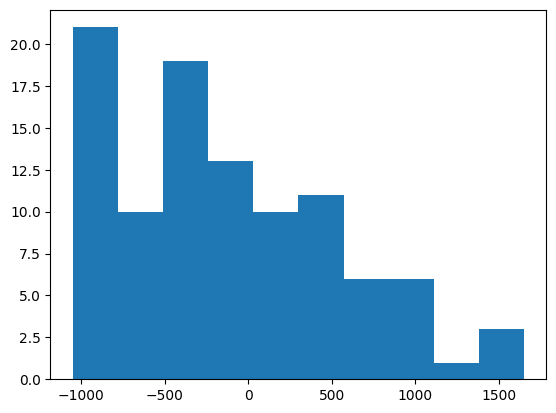

In [388]:
round_winnings,game_winnings=simulate(4, strategy='Dealer')
rounds=pd.DataFrame(round_winnings)
games=pd.DataFrame(game_winnings)
print('Avg Winnings per Round:', rounds[0].mean())
print('Game Winnings STD:', games[0].std())
print('Probability of Net Winning After 50 Rounds:',len(list(games[0][games[0]>0]))/len(games))
print('Probability of Net Losing After 50 Rounds:',1-len(list(games[0][games[0]>0]))/len(games))
_=plt.hist(games)

Card Counting Strategy:

Avg Winnings per Round: -37.835733748540285
Game Winnings STD: 189.13946540512737
Probability of Net Winning After 50 Rounds: 0.01
Probability of Net Losing After 50 Rounds: 0.99


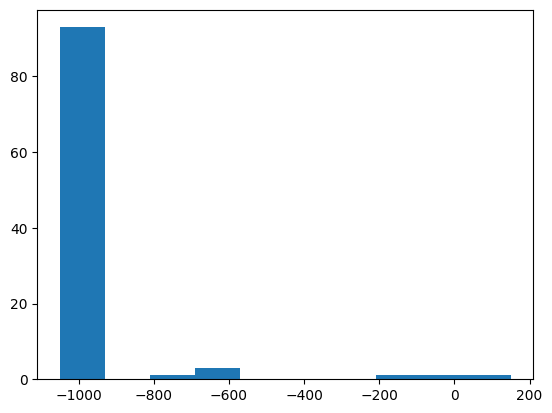

In [415]:
# Threshold of 0
round_winnings,game_winnings=simulate(4, threshold=0)
rounds=pd.DataFrame(round_winnings)
games=pd.DataFrame(game_winnings)
print('Avg Winnings per Round:', rounds[0].mean())
print('Game Winnings STD:', games[0].std())
print('Probability of Net Winning After 50 Rounds:',len(list(games[0][games[0]>0]))/len(games))
print('Probability of Net Losing After 50 Rounds:',1-len(list(games[0][games[0]>0]))/len(games))
_=plt.hist(games)

Avg Winnings per Round: -35.399197958439665
Game Winnings STD: 221.92682386659607
Probability of Net Winning After 50 Rounds: 0.01
Probability of Net Losing After 50 Rounds: 0.99


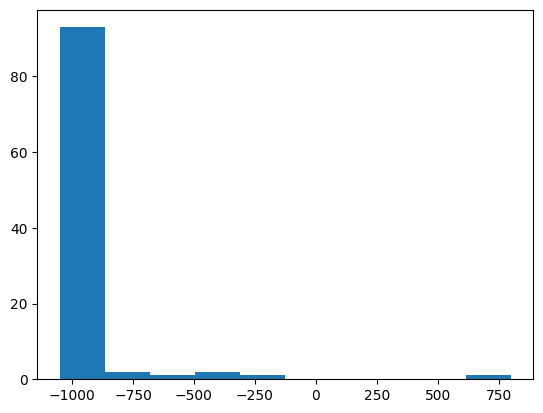

In [397]:
# Threshold of -2
round_winnings,game_winnings=simulate(4, threshold=-2)
rounds=pd.DataFrame(round_winnings)
games=pd.DataFrame(game_winnings)
print('Avg Winnings per Round:', rounds[0].mean())
print('Game Winnings STD:', games[0].std())
print('Probability of Net Winning After 50 Rounds:',len(list(games[0][games[0]>0]))/len(games))
print('Probability of Net Losing After 50 Rounds:',1-len(list(games[0][games[0]>0]))/len(games))
_=plt.hist(games)

Avg Winnings per Round: -27.584615384615386
Game Winnings STD: 304.532677253446
Probability of Net Winning After 50 Rounds: 0.03
Probability of Net Losing After 50 Rounds: 0.97


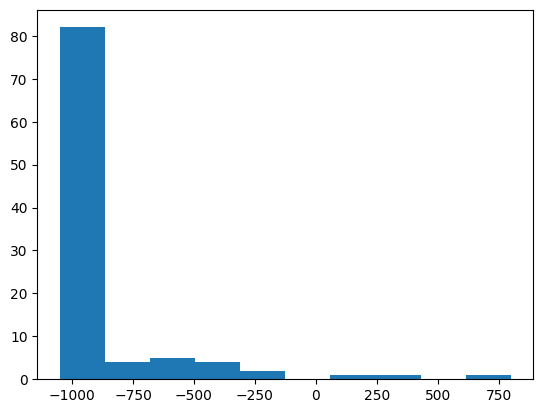

In [399]:
# Threshold of -4
round_winnings,game_winnings=simulate(4, threshold=-4)
rounds=pd.DataFrame(round_winnings)
games=pd.DataFrame(game_winnings)
print('Avg Winnings per Round:', rounds[0].mean())
print('Game Winnings STD:', games[0].std())
print('Probability of Net Winning After 50 Rounds:',len(list(games[0][games[0]>0]))/len(games))
print('Probability of Net Losing After 50 Rounds:',1-len(list(games[0][games[0]>0]))/len(games))
_=plt.hist(games)

Avg Winnings per Round: -23.849737914967967
Game Winnings STD: 408.04906617224407
Probability of Net Winning After 50 Rounds: 0.08
Probability of Net Losing After 50 Rounds: 0.92


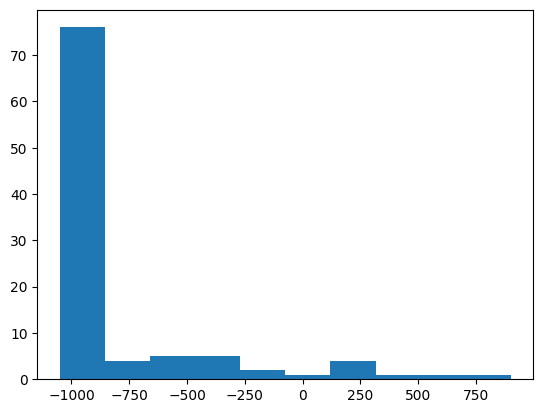

In [401]:
# Threshold of -5
round_winnings,game_winnings=simulate(4, threshold=-5)
rounds=pd.DataFrame(round_winnings)
games=pd.DataFrame(game_winnings)
print('Avg Winnings per Round:', rounds[0].mean())
print('Game Winnings STD:', games[0].std())
print('Probability of Net Winning After 50 Rounds:',len(list(games[0][games[0]>0]))/len(games))
print('Probability of Net Losing After 50 Rounds:',1-len(list(games[0][games[0]>0]))/len(games))
_=plt.hist(games)

Avg Winnings per Round: -22.571743929359823
Game Winnings STD: 377.35924528226417
Probability of Net Winning After 50 Rounds: 0.04
Probability of Net Losing After 50 Rounds: 0.96


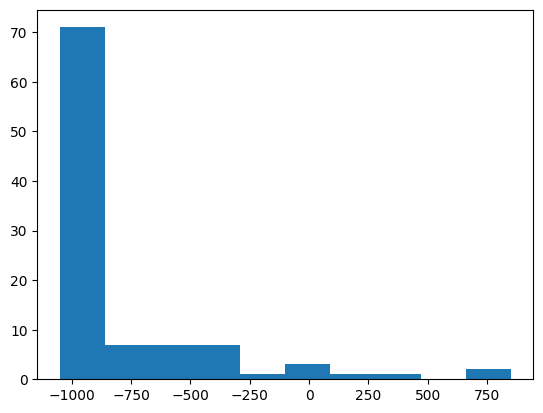

In [405]:
# Threshold of -6
round_winnings,game_winnings=simulate(4, threshold=-6)
rounds=pd.DataFrame(round_winnings)
games=pd.DataFrame(game_winnings)
print('Avg Winnings per Round:', rounds[0].mean())
print('Game Winnings STD:', games[0].std())
print('Probability of Net Winning After 50 Rounds:',len(list(games[0][games[0]>0]))/len(games))
print('Probability of Net Losing After 50 Rounds:',1-len(list(games[0][games[0]>0]))/len(games))
_=plt.hist(games)

Unique Strategy:

Avg Winnings per Round: -5.277897457992244
Game Winnings STD: 654.0665335445855
Probability of Net Winning After 50 Rounds: 0.32
Probability of Net Losing After 50 Rounds: 0.6799999999999999


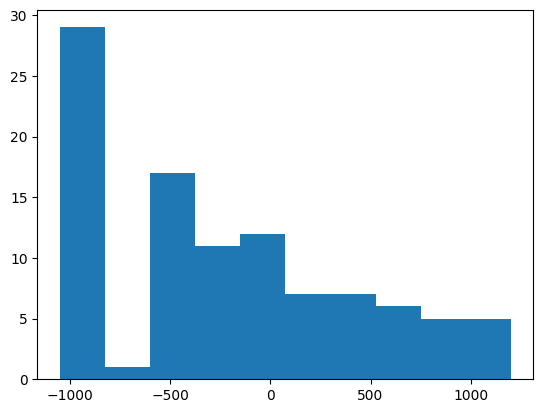

In [394]:
# Unique Strategy
round_winnings,game_winnings=simulate(4, strategy='Unique')
rounds=pd.DataFrame(round_winnings)
games=pd.DataFrame(game_winnings)
print('Avg Winnings per Round:', rounds[0].mean())
print('Game Winnings STD:', games[0].std())
print('Probability of Net Winning After 50 Rounds:',len(list(games[0][games[0]>0]))/len(games))
print('Probability of Net Losing After 50 Rounds:',1-len(list(games[0][games[0]>0]))/len(games))
_=plt.hist(games)